### Model Architecture

In [1]:
import torch

In [2]:
class conv_block(torch.nn.Module):
  def __init__(self, in_channels:int, out_channels:int):
    super(conv_block, self).__init__()
    self.conv1 = torch.nn.Conv2d(in_channels, out_channels, 3, padding=1)
    self.bn1 = torch.nn.BatchNorm2d(out_channels)
    self.conv2 = torch.nn.Conv2d(out_channels, out_channels, 3, padding=1)
    self.bn2 = torch.nn.BatchNorm2d(out_channels)
    self.relu = torch.nn.ReLU()

  def forward(self, inputs):
    x = self.relu(self.bn1(self.conv1(inputs)))
    x = self.relu(self.bn2(self.conv2(x)))
    return x

In [3]:
class encoder_block(torch.nn.Module):
  def __init__(self, in_channels:int, out_channels:int):
    super(encoder_block, self).__init__()
    self.conv = conv_block(in_channels, out_channels)
    self.maxpool = torch.nn.MaxPool2d((2,2))

  def forward(self, inputs):
    x = self.conv(inputs)
    p = self.maxpool(x)
    return x, p

In [4]:
class decoder(torch.nn.Module):
  def __init__(self, in_channels:int, out_channels:int):
    super(decoder, self).__init__()
    self.upsample = torch.nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
    self.conv = conv_block(out_channels+out_channels, out_channels)

  def forward(self, inputs, skip_connections):
    x = self.upsample(inputs)
    x = torch.cat((x, skip_connections), 1)
    return self.conv(x)

In [5]:
class uNetModel(torch.nn.Module):
  def __init__(self, n_classes):
    super(uNetModel, self).__init__()
    #--------------------------
    # Encoder
    #--------------------------
    self.encoder1 = encoder_block(3, 64)
    self.encoder2 = encoder_block(64, 128)
    self.encoder3 = encoder_block(128, 256)
    self.encoder4 = encoder_block(256, 512)

    #--------------------------
    # Bottleneck
    #--------------------------
    self.bottleneck = conv_block(512, 1024)

    #--------------------------
    # Encoder
    #--------------------------
    self.decoder1 = decoder(1024, 512)
    self.decoder2 = decoder(512, 256)
    self.decoder3 = decoder(256, 128)
    self.decoder4 = decoder(128, 64)

    #--------------------------
    # Classifier
    #--------------------------
    self.classifier = torch.nn.Conv2d(64, n_classes, 1)

  def forward(self, inputs):
    x1, p1 = self.encoder1(inputs)
    x2, p2 = self.encoder2(p1)
    x3, p3 = self.encoder3(p2)
    x4, p4 = self.encoder4(p3)
    b = self.bottleneck(p4)

    d1 = self.decoder1(b, x4)
    d2 = self.decoder2(d1, x3)
    d3 = self.decoder3(d2, x2)
    d4 = self.decoder4(d3, x1)

    output = self.classifier(d4)
    return output

### Dataset Preparation

In [6]:
import torch
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision import transforms
import matplotlib.pyplot as plt
import cv2
import os
from PIL import Image, ImageOps
import numpy as np
import random
from tqdm import tqdm

In [7]:
def enhance_contrast(image:Image, show_image:bool):    
    image = np.array(image)
    image = cv2.resize(image, (224,224))
    r,g,b = cv2.split(image) #extract out green channel

    green_channel = cv2.cvtColor(g, cv2.COLOR_GRAY2RGB)  # convert green channel to RGB
    lab = cv2.cvtColor(green_channel, cv2.COLOR_RGB2LAB)  # convert rgb image to lab channels

    L, a, b = cv2.split(lab)  # split lab channels

    clahe = cv2.createCLAHE(clipLimit=3, tileGridSize=(8, 8))  # create CLAHE
    cL = clahe.apply(L)  # apply CLAHE to enhance contrast

    new_img = cv2.merge((cL, a, b))  # create new lab enhanced image
    enhanced_img = cv2.cvtColor(new_img, cv2.COLOR_LAB2RGB) # convert from lab to rgb


    if show_image:
        cv2.imshow("", enhanced_img)
        cv2.waitKey(10000)
        cv2.destroyAllWindows()
    
    return Image.fromarray(enhanced_img)

In [8]:
class ToTensorWithoutScaling(object):
    def __call__(self, pic):
        """|
        Convert a PIL Image or numpy.ndarray to tensor without normalizing.
        """
        return (transforms.functional.to_tensor(pic) * 255).to(torch.int64)


In [9]:
class SegmentationDataset(Dataset):
  def __init__(self, image_paths, mask_paths, transform, mask_transform, mean, std):
    self.image_paths = image_paths
    self.image_list = os.listdir(image_paths)
    self.mask_paths = mask_paths
    self.mask_list = os.listdir(mask_paths)
    self.transform = transform
    self.mask_transform = mask_transform
    self.mean = mean
    self.std = std

    if len(self.image_list) != len(self.mask_list):
      raise Exception(f"Image-Mask pair size misaligned, Image directory contains {len(self.image_list)} images but Mask directory contains {len(self.mask_list)}")

  def __len__(self):
    return len(self.image_list)

  def __getitem__(self, idx):
    image_path = f"{self.image_paths}/{self.image_list[idx]}"
    image = Image.open(image_path)
    enhanced_image = enhance_contrast(image, False) #enhance contrast of image

    mask_path = f"{self.mask_paths}/{self.image_list[idx][:-4]}.png"
    mask = Image.open(mask_path)
    thresh = 50
    fn = lambda x : 1 if x > thresh else 0
    mask = mask.convert('L').point(fn, mode='L')

    seed = np.random.randint(2147483647) # make a seed with numpy generator

    if self.transform is not None:
      random.seed(seed) # apply this seed to img transforms
      torch.manual_seed(seed)
      enhanced_image = self.transform(enhanced_image)
      random.seed(seed) # apply this seed to img transforms
      torch.manual_seed(seed)
      mask = self.mask_transform(mask)
    
    #normalising image
    mean = torch.tensor(self.mean).reshape(-1, 1, 1)
    std = torch.tensor(self.std).reshape(-1, 1, 1)

    enhanced_image = ( enhanced_image - mean )/std

    return enhanced_image, mask

In [10]:
def unnormalize(image:np.array, mean:np.array, std:np.array):
    """
    Function to unnormalize an image given its mean and std

    Args:
        image (np.array): Numpy array of the image
        mean (np.array): Numpy array of the mean
        std (np.array): Numpy array of the std

    Returns:
        Unnormalised numpy array of the image
    """

    for t, m, s in zip(image, mean, std):
        t.mul_(s).add_(m)    # for inplace operations
    return image


def visualise_dataset(dataloader, mean=[0.2816, 0.2817, 0.2816], std=[0.1992, 0.1991, 0.1991]):
  images, masks = next(iter(dataloader))
  print(f"Image batch shape: {images.size()}")
  print(f"Masks batch shape: {masks.size()}")

  fig, axs = plt.subplots(9, 2, figsize=(10, 30))

  for i in range(9):
    img = images[i].squeeze()
    img = unnormalize(img, mean, std)  # Unnormalize the image
    img = np.transpose(img.numpy(), (1, 2, 0))

    mask = masks[i].squeeze()
    mask = mask.numpy()

    axs[i, 0].imshow(img)
    axs[i, 0].axis('off')
    axs[i, 0].set_title('Image')

    axs[i, 1].imshow(mask.squeeze(), cmap='gray')
    axs[i, 1].axis('off')
    axs[i, 1].set_title('Mask')

  plt.tight_layout()
  plt.show()

In [11]:
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
])

mask_transform = transforms.Compose([
    transforms.Resize((512, 512)),
    ToTensorWithoutScaling()
])

aug_transform = transforms.Compose([
    transforms.Resize((1024, 1024)),
    transforms.RandomResizedCrop((512,512)),
    transforms.ColorJitter(brightness=(1,1.5)),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomVerticalFlip(0.5),
    transforms.RandomRotation((-45,45)),
    transforms.ToTensor(),
])

mask_augtransform = transforms.Compose([
    transforms.Resize((1024, 1024)),
    transforms.RandomResizedCrop((512,512)),
    transforms.ColorJitter(brightness=(1,1.5)),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomVerticalFlip(0.5),
    transforms.RandomRotation((-45,45)),
    ToTensorWithoutScaling()
])

# Initialize your dataset - 1/3 unagumented and 2/3 augmented
train_dataset = SegmentationDataset(image_paths = '../input/IDRID_Merged/train/images',
                              mask_paths = '../input/IDRID_Merged/train/masks',
                              mask_transform = mask_transform,
                              transform=transform,
                              mean=[0.2816, 0.2817, 0.2816],
                              std=[0.1992, 0.1991, 0.1991])
total_data = [train_dataset]
#augmented data
for i in range(2):
  augmented_data = SegmentationDataset(image_paths = '../input/IDRID_Merged/train/images',
                              mask_paths = '../input/IDRID_Merged/train/masks',
                              mask_transform = mask_augtransform,
                              transform=aug_transform,
                              mean=[0.2816, 0.2817, 0.2816],
                              std=[0.1992, 0.1991, 0.1991])
  total_data.append(augmented_data)

total_train_dataset = ConcatDataset(total_data)

test_dataset = SegmentationDataset(image_paths = '../input/IDRID_Merged/test/images',
                              mask_paths = '../input/IDRID_Merged/test/masks',
                              transform=transform,
                              mask_transform = mask_transform,
                              mean=[0.2816, 0.2817, 0.2816],
                              std=[0.1992, 0.1991, 0.1991])

# Initialize the dataloader
train_dataloader = DataLoader(total_train_dataset, batch_size=9, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=9, shuffle=False)

Image batch shape: torch.Size([9, 3, 512, 512])
Masks batch shape: torch.Size([9, 1, 512, 512])


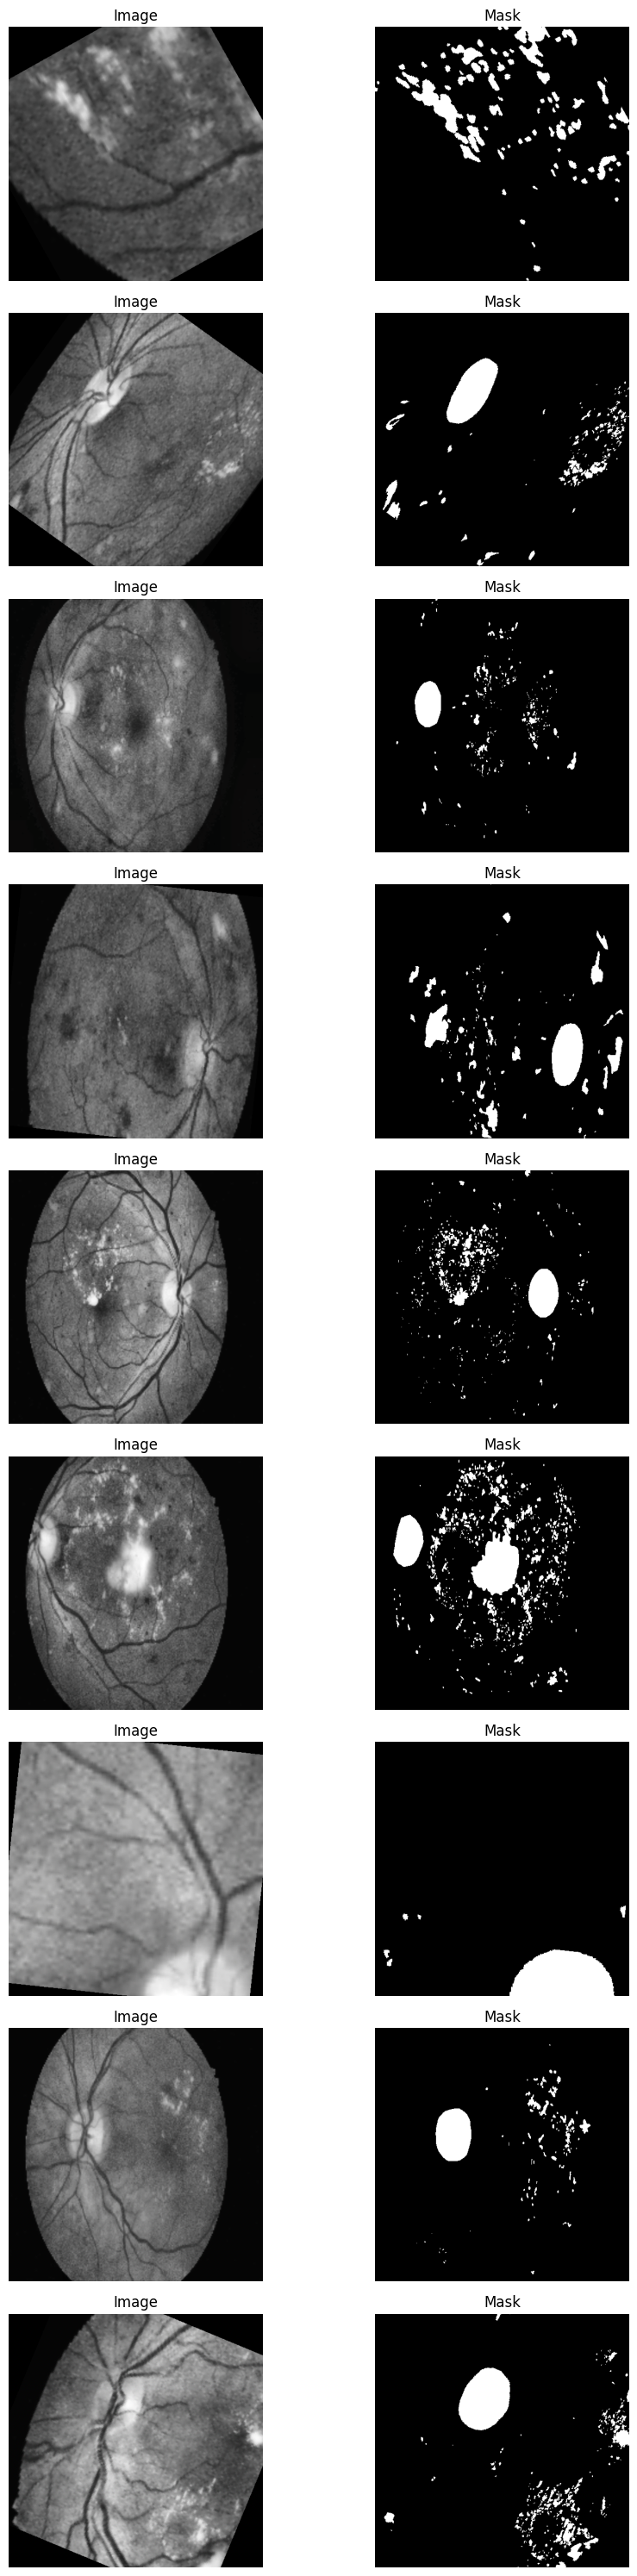

In [12]:
visualise_dataset(train_dataloader)

### Loss Functions

In [13]:
from torch import Tensor

def one_hot_encode(n_classes:int, y:Tensor):
    """
    Function that converts input into tensor with one hot encoding for each class
    Eg. [1,2,0,1,1] -> [[0, 0, 1, 0, 0], [1, 0, 0, 1, 1], [0, 1, 0, 0, 0]]

    Args:
        n_classes (int): number of classes in y
        y (Tensor): input to be split into one hot encoding

    Returns:
        tensor object of one hot encoding
    """
    y = y.long() #convert to ints first (class values)
    batch_size, _, height, width = y.size()
    one_hot = torch.zeros(batch_size, n_classes, height, width, device=y.device) #create base case
    return one_hot.scatter_(1, y, 1)


class DiceLoss(torch.nn.Module):
    """
    Function to calculate Dice Loss
        DL(y,p) = 1 - 2(yp + e) / (y + p + e) 
    
    where y = y_true, p = y_pred, e = epsilon to ensure no divisible by 0

    Args:
        n_classes (int): number of classes 
        reduction (str, optional): Reduction method, either only mean or sum. Defaults to mean
        eps (float, optional): Value to avoid undefined edge cases. Defaults to 1e-6.

    Returns:
        dice loss
    """
    def __init__(self, n_classes:int, reduction:str="mean", eps:float=1e-6):
        super(DiceLoss, self).__init__()
        self.n_classes = n_classes
        self.epsilon = eps
        
        if reduction in ["mean", "sum"]:
            self.reduction = reduction
        else:
            raise Exception("Invalid Reduction Method Selected. Please choose between mean and sum.")
    
    
    def forward(self, y_pred:Tensor, y_true:Tensor):
        """
        y_pred (Tensor): model prediction
        y_true (Tensor): true value
        """
        if self.n_classes == 1: #binary classification, of 1 or 0s, sigmoid
            y_pred = torch.nn.functional.sigmoid(y_pred)

        if self.n_classes > 1: #multiclass classification
            y_pred = torch.nn.functional.softmax(y_pred, dim=1)
            y_true =  one_hot_encode(self.n_classes, y_true)

        assert y_true.size() == y_pred.size() #checking pred and true has the same size

        intersection = (y_pred * y_true).sum(dim=(2, 3)) #yp
        union = y_pred.sum(dim=(2,3)) + y_true.sum(dim=(2,3)) #y+p

        soft_dice_loss = (2.0* (intersection + self.epsilon)) / (union + self.epsilon)
        
        if self.reduction  == "mean":
            return 1.0 - torch.mean(soft_dice_loss)
        
        else:
            return 1.0 - torch.sum(soft_dice_loss)



class FocalLoss(torch.nn.Module):
    """
    Function to calculate Focal Loss
        FL(p, y) = -alpha * ((1-pt) ** gamma) * log(pt) 
    where log(pt) is the cross entropy loss, p = prediction, y = true value

    Args:
        n_classes (int): num of classes
        alpha (float, optional): alpha value, adds weights to help with class imbalance. Defaults to 0.25.
        gamma (float, optional): gamma value, controls the shape of loss curve for pioritising. Defaults to 2.0.
        reduction (str, optional): reudction method, either none, mean or sum. Defaults to "mean".
    """
    def __init__(self, n_classes:int, weights:Tensor=None, alpha:float=0.75, gamma:float=2.0, reduction:str="mean"):
        super(FocalLoss, self).__init__()
        self.n_classes = n_classes
        self.weights = weights
        self.alpha = alpha
        self.gamma = gamma

        if reduction in ["none", "mean", "sum"]:
            self.reduction = reduction
        else:
            raise Exception("Invalid Reduction Method Selected. Please choose between none, mean and sum.")
    
    
    def forward(self, y_pred:Tensor, y_true:Tensor):
        """
        y_pred (Tensor): model prediction
        y_true (Tensor): true value
        """
        if self.n_classes == 1: #binary classification, of 1 or 0s, sigmoid
            loss = torch.nn.functional.binary_cross_entropy_with_logits(y_pred, y_true.float(), pos_weight=self.weights, reduction=self.reduction) #-log(pt)

        if self.n_classes > 1: #multiclass classification
            y_true = torch.squeeze(y_true.long(), dim=1) #squeeze class layer as cross entropy expect (batch_size, h, w)
            loss = torch.nn.functional.cross_entropy(y_pred, y_true, weight=self.weights,  reduction=self.reduction) #-log(pt)

        exp_loss = torch.exp(-loss) #pt
        focal_loss = self.alpha * torch.pow((1.0-exp_loss), self.gamma) * loss
        #reduction already done in the loss calculation, just return focal loss

        return focal_loss
    


class TverskyLoss(torch.nn.Module):
    def __init__(self, n_classes:int, beta:float=0.5, eps:float=1e-6):
        super(TverskyLoss, self).__init__()
        self.n_classes = n_classes
        self.beta = beta
        self.eps = eps

    def forward(self, y_pred:Tensor, y_true:Tensor):
        """
        y_pred (Tensor): model prediction
        y_true (Tensor): true value
        """
        if self.n_classes == 1: #binary classification, of 1 or 0s, sigmoid
            y_pred = torch.nn.functional.sigmoid(y_pred)

        if self.n_classes > 1: #multiclass classification
            y_pred = torch.nn.functional.softmax(y_pred, dim=1)
            y_true =  one_hot_encode(self.n_classes, y_true)

        true_positive = (y_pred * y_true).sum(dim=(2, 3)) #yp
        false_negative =  ((1-y_pred) * y_true).sum(dim=(2,3)) #(1-p)y
        false_positive = (y_pred * (1-y_true)).sum(dim=(2,3)) #(1-y)p

        tversky_loss = true_positive / (true_positive + self.beta*false_negative + (1-self.beta)*false_positive + self.eps)
        return 1- torch.mean(tversky_loss)
    


class FocalTverskyLoss(torch.nn.Module):
    def __init__(self, n_classes:int, beta:float=0.5, gamma:float=0.75, eps:float=1e-6):
        super(FocalTverskyLoss, self).__init__()
        self.treversky = TverskyLoss(n_classes, beta, eps)
        self.gamma = gamma

    def forward(self, y_pred:Tensor, y_true:Tensor):
        """
        y_pred (Tensor): model prediction
        y_true (Tensor): true value
        """
        treversky_loss = self.treversky(y_pred, y_true)
        focal_tversky_loss = torch.pow(treversky_loss, self.gamma)
        return focal_tversky_loss


class LogCoshDice(torch.nn.Module):
    def __init__(self, n_classes:int, reduction:str="mean", eps:float=1e-6):
        super(LogCoshDice, self).__init__()
        self.diceloss = DiceLoss(n_classes, reduction, eps)

    def forward(self, y_pred:Tensor, y_true:Tensor):
        """
        y_pred (Tensor): model prediction
        y_true (Tensor): true value
        """
        dice_loss = self.diceloss(y_pred, y_true)
        return torch.log(torch.cosh(dice_loss))
    


def onehot(label, n_classes):
    one_hot_label = torch.eye(
        n_classes, device='cuda', requires_grad=True
    )[label]
    one_hot_label= one_hot_label.transpose(1,3).transpose(2,3)
    return one_hot_label

##CRYING I NEED TIME FOR THIS ONE
class BoundaryLoss(torch.nn.Module):
    def __init__(self, n_classes:int, theta0:int=3, theta:int=5, eps:float=1e-7):
        super(BoundaryLoss, self).__init__()
        self.n_classes = n_classes
        self.theta0 = theta0
        self.theta = theta
        self.eps = eps

    def forward(self, y_pred:Tensor, y_true:Tensor):
        """
        y_pred (Tensor): model prediction
        y_true (Tensor): true value
        """

        
        y_pred = torch.nn.functional.softmax(y_pred, dim=1)
        y_true.squeeze(dim=1).long()
        y_true = onehot(y_true,self.n_classes)

        #boundary map
        gt_b = torch.nn.functional.max_pool2d( 1-y_true, 
                                              kernel_size=self.theta0, 
                                              stride=1,
                                              padding=(self.theta0 -1) //2)
        gt_b -= (1- y_true)

        preb_b = torch.nn.functional.max_pool2d( 1-y_pred,
                                                kernel_size=self.theta0,
                                                padding = (self.theta0-1)//2)
        preb_b -= (1- y_pred)

        gt_b_ext = torch.nn.functional.max_pool2d( 1-y_true, 
                                        kernel_size=self.theta, 
                                        padding=(self.theta -1) //2)

        preb_b_ext = torch.nn.functional.max_pool2d( 1-y_pred,
                                                kernel_size=self.theta,
                                                padding = (self.theta-1)//2)

        #reshape and flatten
        gt_b = gt_b.view(y_pred.shape[0], self.n_classes, -1)
        preb_b = gt_b.view(y_pred.shape[0], self.n_classes, -1)
        gt_b_ext = gt_b.view(y_pred.shape[0], self.n_classes, -1)
        preb_b_ext = gt_b.view(y_pred.shape[0], self.n_classes, -1)


        #precision recall
        P = torch.sum(preb_b * gt_b_ext, dim=2) / (torch.sum(preb_b, dim=2) + self.eps)
        R = torch.sum(preb_b_ext* gt_b, dim=2) / (torch.sum(gt_b, dim=2) + self.eps)

        BF1 = 2*P*R / (P +R + self.eps)
        boundary_loss = torch.mean(1-BF1)

        return boundary_loss

In [18]:
def train(model, criterion, optimiser, dataloader, num_epochs, device):
  model.to(device)
  model.train()
  loss_container = []

  for epoch in range(num_epochs):
    total_loss = 0
    for idx, (image, mask) in enumerate(tqdm(dataloader)):
      (image, mask) = (image.to(device), mask.to(device))
      outputs = model(image)

      loss = criterion(outputs, mask)
      optimiser.zero_grad()
      loss.backward()
      optimiser.step()

      total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    if len(loss_container) >0  and avg_loss < min(loss_container):
      torch.save(model, "4.pt")
    loss_container.append(avg_loss)
    print(f"Epoch {epoch+1} completed, training loss: {avg_loss:.2f}")
    

  return loss_container

In [15]:
import gc
torch.cuda.empty_cache()
gc.collect()

44862

In [16]:
model = uNetModel(1)
criterion = BoundaryLoss(1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [17]:
training_loss = train(
    model,
    criterion,
    optimizer,
    train_dataloader,
    30,
    'cuda'
)

  0%|          | 0/18 [00:00<?, ?it/s]

torch.Size([9, 512, 1, 512, 1])


  0%|          | 0/18 [00:01<?, ?it/s]


RuntimeError: non-empty 3D or 4D (batch mode) tensor expected for input

In [ ]:
model2 = uNetModel(6)
criterion2 = LogCoshDice(6)
optimizer2 = torch.optim.Adam(model2.parameters(), lr=0.001)

In [ ]:
training_loss = train(
    model2,
    criterion2,
    optimizer2,
    train_dataloader1,
    30,
    'cuda'
)

### Training

In [ ]:
def train(model, criterion, optimiser, dataloader, num_epochs, device):
  model.to(device)
  model.train()
  loss_container = []

  for epoch in range(num_epochs):
    total_loss = 0
    for idx, (image, mask) in enumerate(tqdm(dataloader)):
      (image, mask) = (image.to(device), mask.to(device))
      outputs = model(image)

      loss = criterion(outputs, mask.float())
      # loss = dice_loss(outputs, mask)
      optimiser.zero_grad()
      loss.backward()
      optimiser.step()

      total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    if len(loss_container) >0  and avg_loss < min(loss_container):
      torch.save(model, "4.pt")
    loss_container.append(avg_loss)
    print(f"Epoch {epoch+1} completed, training loss: {avg_loss:.2f}")
    

  return loss_container

In [ ]:
import gc
torch.cuda.empty_cache()
gc.collect()

45768

In [ ]:
import torch
from torch import Tensor

def dice_coeff(input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon: float = 1e-6):
    # Average of Dice coefficient for all batches, or for a single mask
    assert input.size() == target.size()
    assert input.dim() == 3 or not reduce_batch_first

    sum_dim = (-1, -2) if input.dim() == 2 or not reduce_batch_first else (-1, -2, -3)

    inter = 2 * (input * target).sum(dim=sum_dim)
    sets_sum = input.sum(dim=sum_dim) + target.sum(dim=sum_dim)
    sets_sum = torch.where(sets_sum == 0, inter, sets_sum)

    dice = (inter + epsilon) / (sets_sum + epsilon)
    return dice.mean()


def multiclass_dice_coeff(input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon: float = 1e-6):
    # Average of Dice coefficient for all classes
    return dice_coeff(input.flatten(0, 1), target.flatten(0, 1), reduce_batch_first, epsilon)


def dice_loss(input: Tensor, target: Tensor, multiclass: bool = False):
    # Dice loss (objective to minimize) between 0 and 1
    fn = multiclass_dice_coeff if multiclass else dice_coeff
    return 1 - fn(input, target, reduce_batch_first=False)

In [ ]:
import numpy as np

# Assuming you have your mask data loaded into a numpy array `mask_data`
# mask_data should be a 2D array where each pixel value represents the class label
# For example, if you have 5 classes, each pixel value could be an integer from 0 to 4

# Calculate class frequencies
class_frequencies = np.zeros(2)
for idx, (image, mask) in enumerate(train_dataloader):
    class_frequencies += np.bincount(mask.flatten(), minlength=2)

pos_weight = class_frequencies[0]/class_frequencies[1]
print(class_frequencies)
print(pos_weight)

[40538275.  1929053.]
21.01459887312583


In [ ]:
model = uNetModel(1)
criterion = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor(3, dtype=torch.float32).cuda())
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
criterion = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor(5, dtype=torch.float32).cuda())


In [ ]:
training_loss = train(
    model,
    criterion,
    optimizer,
    train_dataloader,
    30,
    'cuda'
)

100%|██████████| 18/18 [00:23<00:00,  1.33s/it]


Epoch 1 completed, training loss: 0.16


100%|██████████| 18/18 [00:23<00:00,  1.31s/it]


Epoch 2 completed, training loss: 0.15


100%|██████████| 18/18 [00:23<00:00,  1.31s/it]


Epoch 3 completed, training loss: 0.17


100%|██████████| 18/18 [00:23<00:00,  1.31s/it]


Epoch 4 completed, training loss: 0.16


100%|██████████| 18/18 [00:23<00:00,  1.31s/it]


Epoch 5 completed, training loss: 0.14


100%|██████████| 18/18 [00:23<00:00,  1.31s/it]


Epoch 6 completed, training loss: 0.16


100%|██████████| 18/18 [00:23<00:00,  1.32s/it]


Epoch 7 completed, training loss: 0.14


100%|██████████| 18/18 [00:23<00:00,  1.31s/it]


Epoch 8 completed, training loss: 0.15


100%|██████████| 18/18 [00:23<00:00,  1.31s/it]


Epoch 9 completed, training loss: 0.15


100%|██████████| 18/18 [00:23<00:00,  1.31s/it]


Epoch 10 completed, training loss: 0.16


100%|██████████| 18/18 [00:23<00:00,  1.31s/it]


Epoch 11 completed, training loss: 0.13


100%|██████████| 18/18 [00:23<00:00,  1.31s/it]


Epoch 12 completed, training loss: 0.14


100%|██████████| 18/18 [00:23<00:00,  1.30s/it]


Epoch 13 completed, training loss: 0.13


100%|██████████| 18/18 [00:23<00:00,  1.29s/it]


Epoch 14 completed, training loss: 0.13


100%|██████████| 18/18 [00:23<00:00,  1.29s/it]


Epoch 15 completed, training loss: 0.14


100%|██████████| 18/18 [00:23<00:00,  1.30s/it]


Epoch 16 completed, training loss: 0.13


100%|██████████| 18/18 [00:23<00:00,  1.30s/it]


Epoch 17 completed, training loss: 0.14


100%|██████████| 18/18 [00:23<00:00,  1.29s/it]


Epoch 18 completed, training loss: 0.13


100%|██████████| 18/18 [00:23<00:00,  1.29s/it]


Epoch 19 completed, training loss: 0.14


100%|██████████| 18/18 [00:23<00:00,  1.29s/it]


Epoch 20 completed, training loss: 0.14


100%|██████████| 18/18 [00:23<00:00,  1.29s/it]


Epoch 21 completed, training loss: 0.14


100%|██████████| 18/18 [00:23<00:00,  1.30s/it]


Epoch 22 completed, training loss: 0.16


100%|██████████| 18/18 [00:23<00:00,  1.29s/it]


Epoch 23 completed, training loss: 0.15


100%|██████████| 18/18 [00:23<00:00,  1.29s/it]


Epoch 24 completed, training loss: 0.14


100%|██████████| 18/18 [00:23<00:00,  1.29s/it]


Epoch 25 completed, training loss: 0.14


100%|██████████| 18/18 [00:23<00:00,  1.29s/it]


Epoch 26 completed, training loss: 0.13


100%|██████████| 18/18 [00:23<00:00,  1.29s/it]


Epoch 27 completed, training loss: 0.13


100%|██████████| 18/18 [00:23<00:00,  1.30s/it]


Epoch 28 completed, training loss: 0.13


100%|██████████| 18/18 [00:23<00:00,  1.29s/it]


Epoch 29 completed, training loss: 0.16


100%|██████████| 18/18 [00:23<00:00,  1.29s/it]

Epoch 30 completed, training loss: 0.16


In [ ]:
a = torch.load('2.pt')

In [ ]:
def inference(model, dataloader, num_images, device, mean=[0.2816, 0.2817, 0.2816], std=[0.1992, 0.1991, 0.1991]):
  model.to(device)
  model.eval()
  with torch.no_grad():
    for idx in range(num_images):
        image, mask = next(iter(dataloader))
        
        outputs = model(image.to(device))
        outputs = torch.nn.functional.sigmoid(outputs)
        outputs = (outputs > 0.5).float()
        image = unnormalize(image[idx], mean, std)  # Unnormalize the image
        image_np = np.array(image).transpose(1, 2, 0)
        output_np = np.array(outputs[idx].cpu())
        
        # Display images side by side
        fig, axes = plt.subplots(1, 3, figsize=(10, 5))
        axes[0].imshow(image_np)  # Assuming batch size is 1
        axes[0].set_title('Input')
        axes[0].axis('off')
        axes[1].imshow(output_np.squeeze(), cmap="gray")  # Assuming batch size is 1
        axes[1].set_title('Model Output')
        axes[1].axis('off')
        axes[2].imshow(np.array(mask[idx]).squeeze(), cmap='gray')
        axes[2].set_title('True Value')
        axes[2].axis('off')
        plt.show()

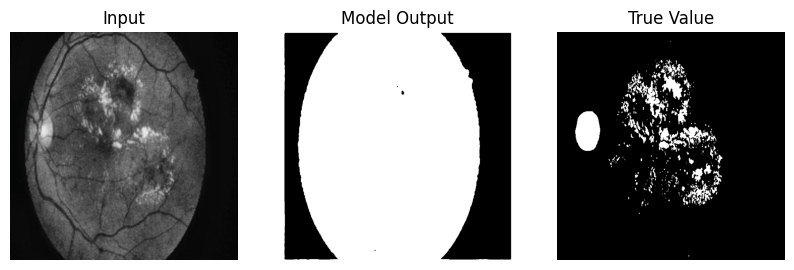

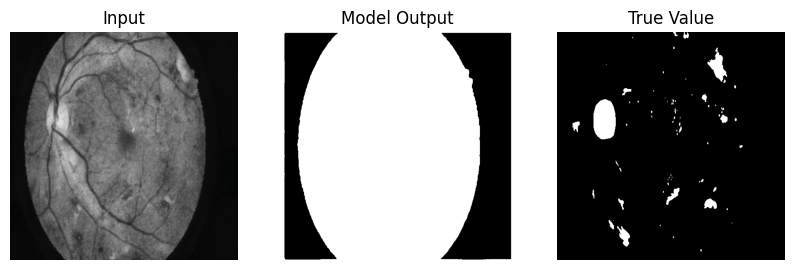

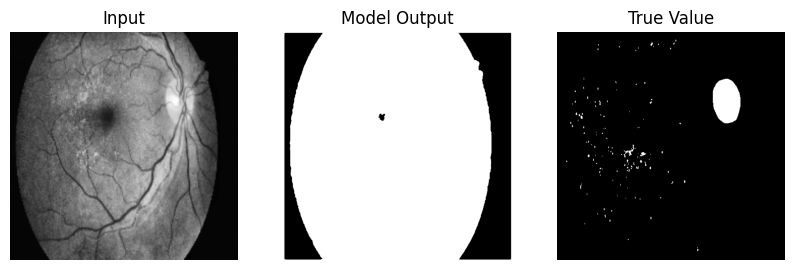

In [ ]:
inference(model, test_dataloader, 3, 'cuda')

C:\Users\valkr\AppData\Local\Temp\ipykernel_17596\1381794507.py:9: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  outputs = torch.nn.functional.softmax(outputs)


{0: 202683, 1: 157, 2: 2933, 3: 5035, 4: 37392, 5: 13944}
{0: 245043, 1: 17101}


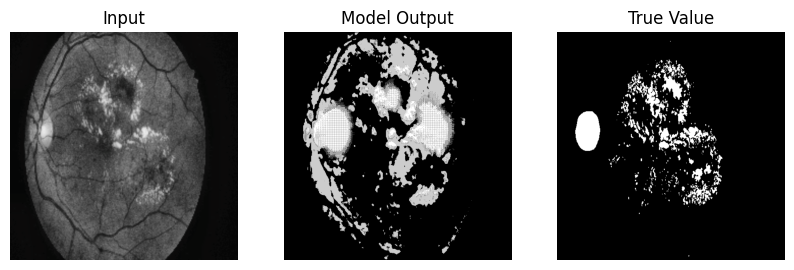

{0: 132494, 1: 477, 2: 784, 3: 13774, 4: 88602, 5: 26013}
{0: 253530, 1: 8614}


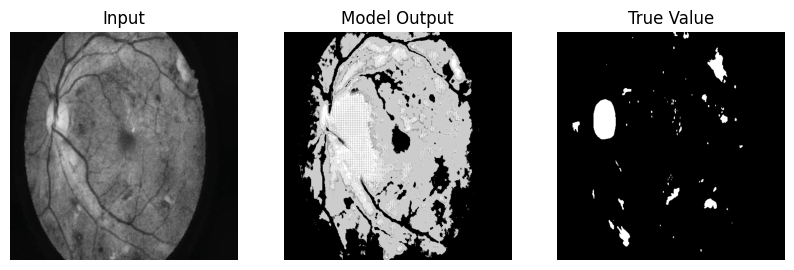

{0: 113729, 1: 554, 2: 1617, 3: 24921, 4: 62124, 5: 59199}
{0: 256146, 1: 5998}


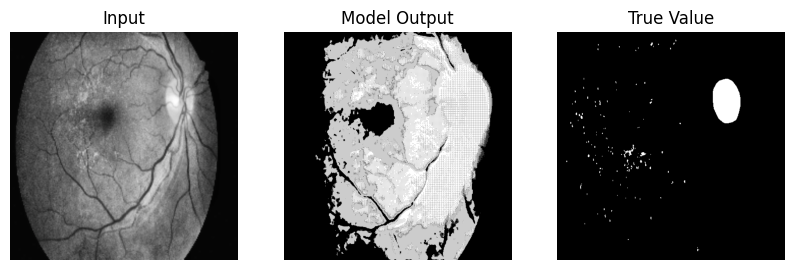

In [ ]:
inference2(model2, test_dataloader, 3, 'cuda')

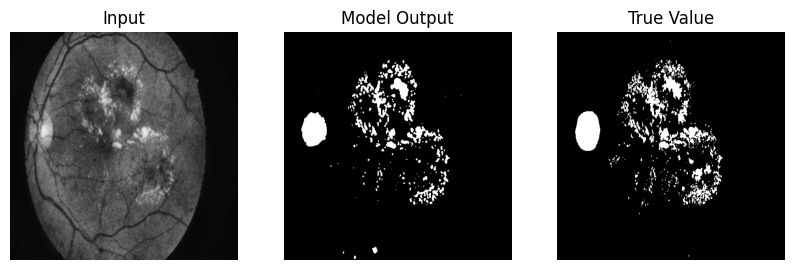

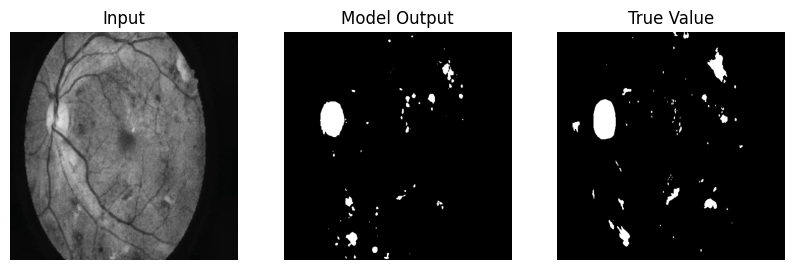

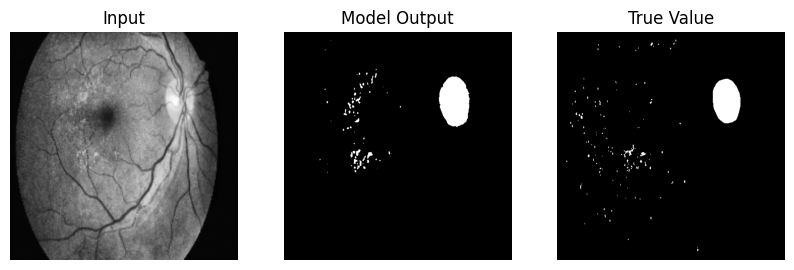

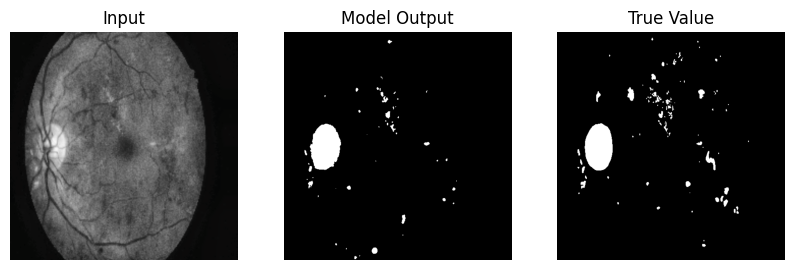

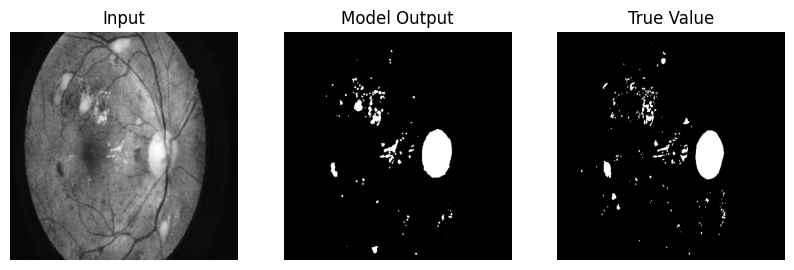

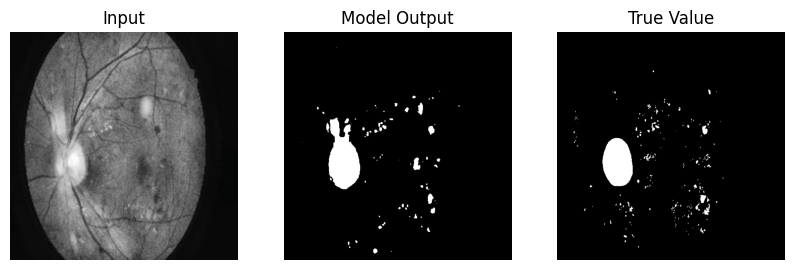

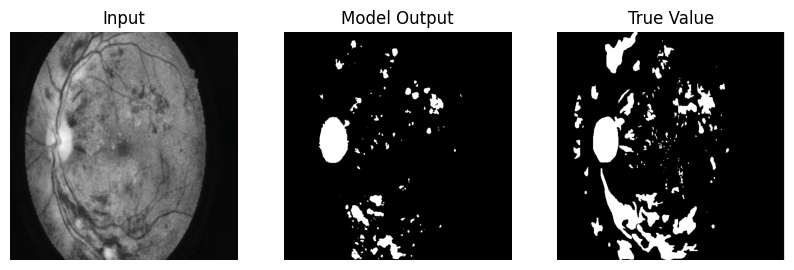

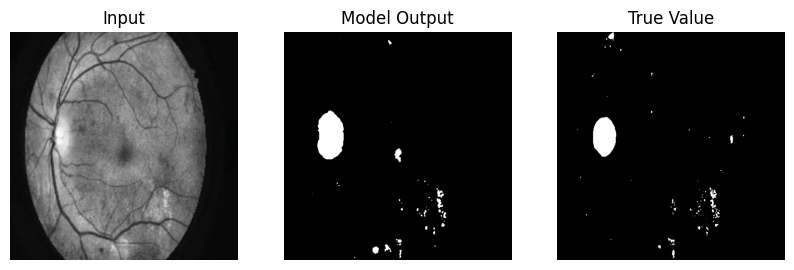

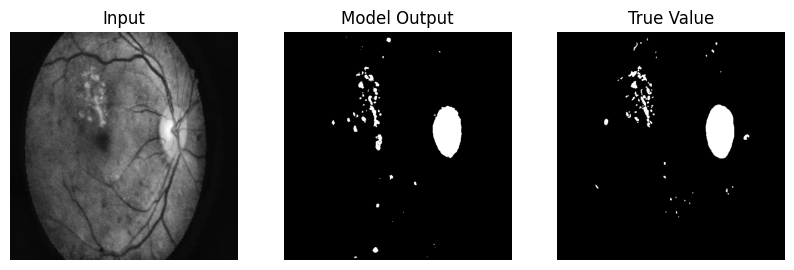

In [ ]:
inference(a, test_dataloader, 9, 'cuda')

### Second try

In [ ]:
def enhance_contrast(image:Image, show_image:bool):    
    image = np.array(image)
    image = cv2.resize(image, (224,224))
    r,g,b = cv2.split(image) #extract out green channel

    green_channel = cv2.cvtColor(g, cv2.COLOR_GRAY2RGB)  # convert green channel to RGB
    lab = cv2.cvtColor(green_channel, cv2.COLOR_RGB2LAB)  # convert rgb image to lab channels

    L, a, b = cv2.split(lab)  # split lab channels

    clahe = cv2.createCLAHE(clipLimit=3, tileGridSize=(8, 8))  # create CLAHE
    cL = clahe.apply(L)  # apply CLAHE to enhance contrast

    new_img = cv2.merge((cL, a, b))  # create new lab enhanced image
    enhanced_img = cv2.cvtColor(new_img, cv2.COLOR_LAB2RGB) # convert from lab to rgb


    if show_image:
        cv2.imshow("", enhanced_img)
        cv2.waitKey(10000)
        cv2.destroyAllWindows()
    
    return Image.fromarray(enhanced_img)

In [ ]:
def unnormalize(image:np.array, mean:np.array, std:np.array):
    """
    Function to unnormalize an image given its mean and std

    Args:
        image (np.array): Numpy array of the image
        mean (np.array): Numpy array of the mean
        std (np.array): Numpy array of the std

    Returns:
        Unnormalised numpy array of the image
    """

    for t, m, s in zip(image, mean, std):
        t.mul_(s).add_(m)    # for inplace operations
    return image


def visualise_dataset(dataloader, mean=[0.2816, 0.2817, 0.2816], std=[0.1992, 0.1991, 0.1991]):
  images, masks = next(iter(dataloader))
  print(f"Image batch shape: {images.size()}")
  print(f"Masks batch shape: {masks.size()}")

  fig, axs = plt.subplots(9, 2, figsize=(10, 30))

  for i in range(9):
    img = images[i].squeeze()
    img = unnormalize(img, mean, std)  # Unnormalize the image
    img = np.transpose(img.numpy(), (1, 2, 0))

    mask = masks[i].squeeze()
    mask = mask.numpy()

    axs[i, 0].imshow(img)
    axs[i, 0].axis('off')
    axs[i, 0].set_title('Image')

    axs[i, 1].imshow(mask.squeeze(), cmap='gray')
    axs[i, 1].axis('off')
    axs[i, 1].set_title('Mask')

  plt.tight_layout()
  plt.show()

In [ ]:
class RetinalDataset(Dataset):
    def __init__(self, image_paths, mask_paths, mask_class, transform, masktransform, mean, std):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.mask_class = mask_class        
        self.transform = transform
        self.masktransform = masktransform
        self.mean = mean
        self.std = std
        
        self.image_list = os.listdir(image_paths)
        self.mask_list = []
        for dir in mask_class:
            self.mask_list.append(os.listdir(f"{mask_paths}/{dir[0]}"))


    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        image_name = self.image_list[idx]
        image_path = f"{self.image_paths}/{image_name}"
        image = Image.open(image_path)
        enhanced_image = enhance_contrast(image, False) #enhance contrast of image
        merged_mask = np.zeros((image.size[1],image.size[0]), dtype=np.uint8)

        for class_idx, mask_dir in enumerate(self.mask_class):
            mask_name = f"{image_name[:-4]}_{mask_dir[1]}.tif"
            if mask_name in self.mask_list[class_idx]:
                mask = Image.open(f"{self.mask_paths}/{mask_dir[0]}/{mask_name}")
                mask_array = np.array(mask)
                merged_mask[mask_array > 0] = class_idx+1

        mask = Image.fromarray(merged_mask)

        
        seed = np.random.randint(2147483647) # make a seed with numpy generator

        if self.transform is not None:
            random.seed(seed) # apply this seed to img transforms
            torch.manual_seed(seed)
            enhanced_image = self.transform(enhanced_image)
            random.seed(seed) # apply this seed to img transforms
            torch.manual_seed(seed)
            mask = self.masktransform(mask)


        #normalising image
        mean = torch.tensor(self.mean).reshape(-1, 1, 1)
        std = torch.tensor(self.std).reshape(-1, 1, 1)

        enhanced_image = ( enhanced_image - mean )/std

        return enhanced_image, mask

In [ ]:
class ToTensorWithoutScaling(object):
    def __call__(self, pic):
        """|
        Convert a PIL Image or numpy.ndarray to tensor without normalizing.
        """
        return (transforms.functional.to_tensor(pic) * 255).to(torch.int64)


In [ ]:
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor()
])

aug_transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomVerticalFlip(0.5),
    transforms.RandomRotation((-45,45)),
    transforms.ToTensor()
])

mask_transform = transforms.Compose([
    transforms.Resize((512, 512)),
    ToTensorWithoutScaling()
])

mask_aug_transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomVerticalFlip(0.5),
    transforms.RandomRotation((-45,45)),
    ToTensorWithoutScaling()
])

train_mask_file = "../input/IDRID/A.%20Segmentation/A. Segmentation/2. All Segmentation Groundtruths/a. Training Set"
test_main_file = "../input/IDRID/A.%20Segmentation/A. Segmentation/2. All Segmentation Groundtruths/b. Testing Set"
class_path = [["1. Microaneurysms","MA"], ["2. Haemorrhages","HE"], ["3. Hard Exudates","EX"], ["4. Soft Exudates","SE"], ["5. Optic Disc", "OD"]]

# Initialize your dataset - 1/3 unagumented and 2/3 augmented
train_dataset = RetinalDataset(image_paths = '../input/IDRID_Merged/train/images',
                              mask_paths = train_mask_file,
                              mask_class=class_path,
                              transform=transform,
                              masktransform=mask_transform,
                              mean=[0.2816, 0.2817, 0.2816],
                              std=[0.1992, 0.1991, 0.1991])
total_data = [train_dataset]
#augmented data
for i in range(2):
  augmented_data = RetinalDataset(image_paths = '../input/IDRID_Merged/train/images',
                              mask_paths = train_mask_file,
                              mask_class=class_path,
                              transform=aug_transform,
                              masktransform=mask_aug_transform,
                              mean=[0.2816, 0.2817, 0.2816],
                              std=[0.1992, 0.1991, 0.1991])
  total_data.append(augmented_data)

total_train_dataset = ConcatDataset(total_data)

test_dataset = RetinalDataset(image_paths = '../input/IDRID_Merged/test/images',
                              mask_paths = test_main_file,
                              mask_class=class_path,
                              transform=transform,
                              masktransform=mask_transform,
                              mean=[0.2816, 0.2817, 0.2816],
                              std=[0.1992, 0.1991, 0.1991])

# Initialize the dataloader
train_dataloader1 = DataLoader(total_train_dataset, batch_size=9, shuffle=True)
test_dataloader1 = DataLoader(test_dataset, batch_size=9, shuffle=False)

Image batch shape: torch.Size([9, 3, 512, 512])
Masks batch shape: torch.Size([9, 1, 512, 512])


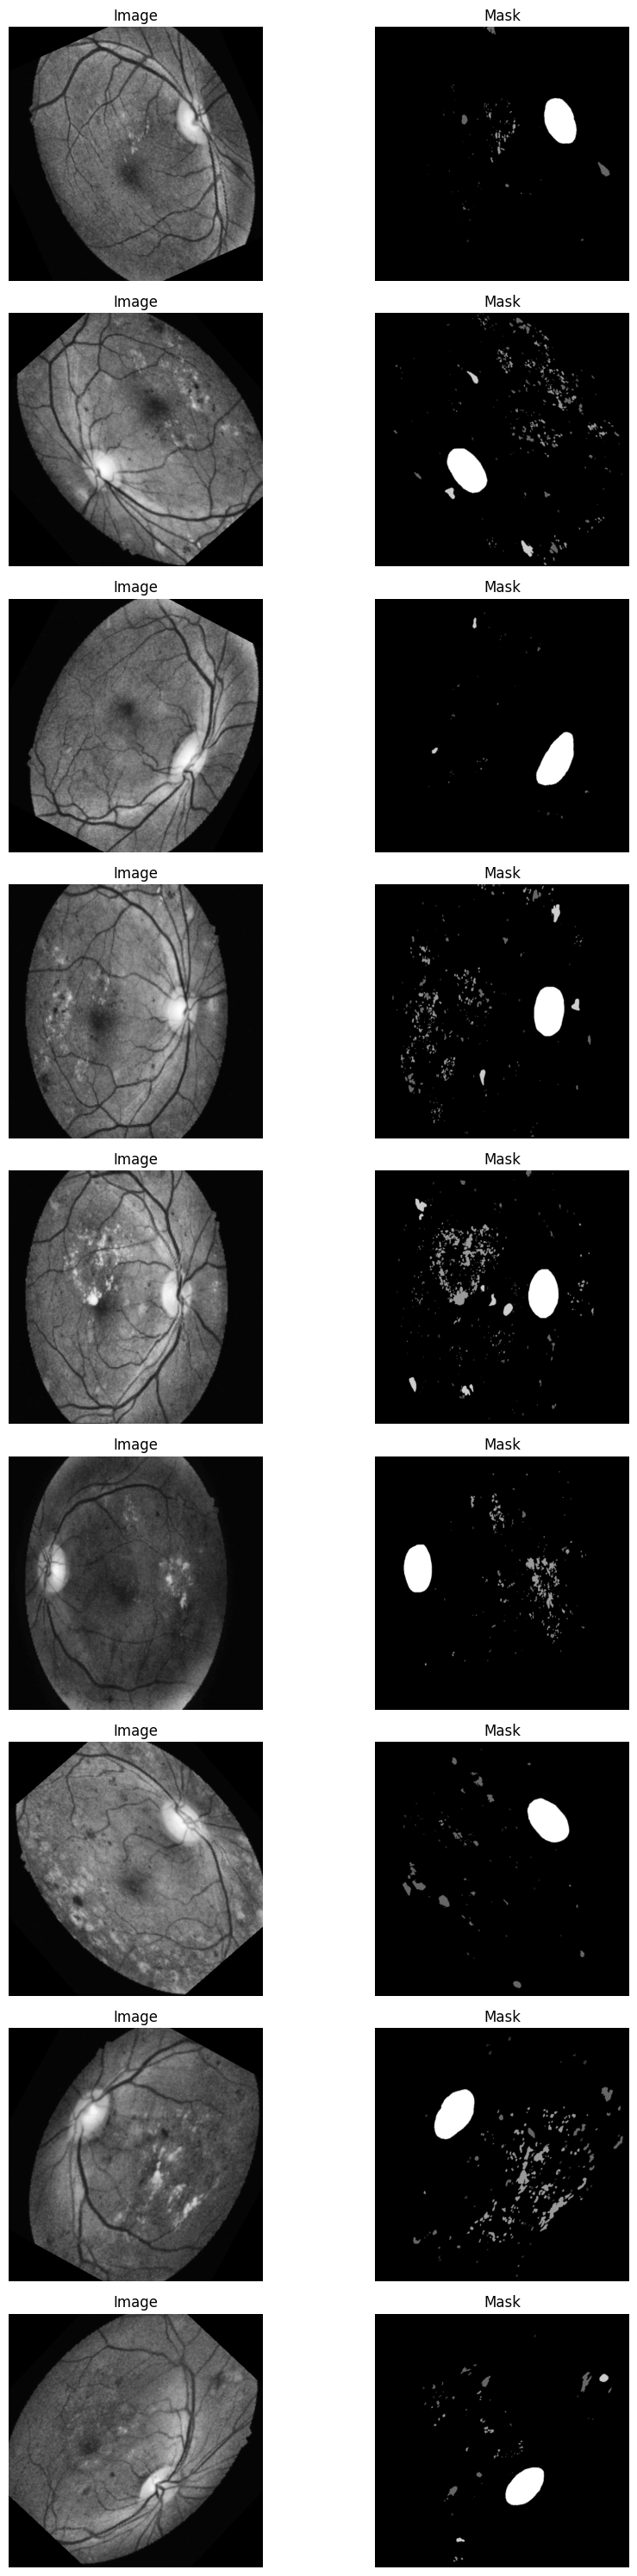

In [ ]:
visualise_dataset(train_dataloader1)

In [ ]:
import numpy as np

# Assuming you have your mask data loaded into a numpy array `mask_data`
# mask_data should be a 2D array where each pixel value represents the class label
# For example, if you have 5 classes, each pixel value could be an integer from 0 to 4

# Calculate class frequencies
class_frequencies = np.zeros(6)
for idx, (image, mask) in enumerate(train_dataloader1):
    class_frequencies += np.bincount(mask.flatten(), minlength=6)
# Compute inverse class frequencies
inverse_class_frequencies = 1 / class_frequencies

# Normalize weights
class_weights = inverse_class_frequencies / np.sum(inverse_class_frequencies)

print("Class Frequencies:", class_frequencies)
print("Inverse Class Frequencies:", inverse_class_frequencies)
print("Class Weights:", class_weights)

Class Frequencies: [40622135.   280218.   492861.   244873.    82730.   744511.]
Inverse Class Frequencies: [2.46171207e-08 3.56865012e-06 2.02896963e-06 4.08374954e-06
 1.20875136e-05 1.34316350e-06]
Class Weights: [0.00106399 0.15424221 0.087695   0.17650555 0.52243979 0.05805347]


In [ ]:
import torch

def one_hot_encode(labels, num_classes):
    # labels: tensor of shape [batch_size, 1, H, W] containing class indices
    # num_classes: int, the number of classes
    batch_size, _, height, width = labels.size()
    one_hot = torch.zeros(batch_size, num_classes, height, width, device=labels.device)
    return one_hot.scatter_(1, labels, 1)

def dice_loss(pred, target, num_classes=6, smooth=1e-6):
    """
    pred: model predictions, tensor of shape [batch_size, num_classes, H, W]
    target: true labels, tensor of shape [batch_size, 1, H, W] with class indices
    num_classes: number of classes, default is 6
    smooth: smoothing factor to avoid division by zero
    """
    target_one_hot = one_hot_encode(target, num_classes)  # Convert target to one-hot encoding
    pred = torch.softmax(pred, dim=1)  # Apply softmax to predictions if not already done
    
    intersection = (pred * target_one_hot).sum(dim=(2, 3))
    union = pred.sum(dim=(2, 3)) + target_one_hot.sum(dim=(2, 3))
    
    dice_score = (2. * intersection + smooth) / (union + smooth)
    dice_loss = 1 - dice_score.mean()  # Average over all classes and batch
    return dice_loss

In [ ]:
def tversky(y_pred, y_true, smooth=1e-6):
    y_pred = torch.softmax(y_pred, dim=1)
    y_true = one_hot_encode(y_true, 6)  # Convert target to one-hot encoding
    y_true_pos = torch.flatten(y_true)
    y_pred_pos = torch.flatten(y_pred)
    true_pos = torch.sum(y_true_pos * y_pred_pos)
    false_neg = torch.sum(y_true_pos * (1 - y_pred_pos))
    false_pos = torch.sum((1 - y_true_pos) * y_pred_pos)
    alpha = 0.7
    return (true_pos + smooth) / (true_pos + alpha * false_neg + (1 - alpha) * false_pos + smooth)

def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true, y_pred)

def focal_tversky(y_pred, y_true, gamma=0.75):
    pt_1 = tversky(y_pred, y_true)
    return torch.pow((1 - pt_1), gamma)

In [ ]:
image, mask = next(iter(train_dataloader1))
unique_values, counts = np.unique(mask[0], return_counts=True)

# Create a dictionary to store counts
count_dict = dict(zip(unique_values, counts))

print("Counts of each value:")
print(count_dict)
a = one_hot_encode(mask,6)
first_image = a[0]

# Counting the number of 1s in each channel of the first image
ones_count_per_channel = torch.sum(first_image, axis=(1,2))

ones_count_per_channel

Counts of each value:
{0: 251710, 1: 1448, 2: 2382, 3: 1364, 4: 781, 5: 4459}


tensor([251710.,   1448.,   2382.,   1364.,    781.,   4459.])

In [ ]:
def train(model, criterion, optimiser, dataloader, num_epochs, include_dice,  n_classes, device):
  model.to(device)
  model.train()
  loss_container = []
  best_model = None

  for epoch in range(num_epochs):
    total_loss = 0
    for idx, (image, mask) in enumerate(tqdm(dataloader)):
      
      (image, mask) = (image.to(device), mask.to(device))
      outputs = model(image)
      # mask_one_hot = one_hot_encode(mask, 6)

      loss = criterion(outputs, torch.squeeze(mask, dim=1))
      # loss = criterion(outputs, (torch.squeeze(mask, dim=1)))
      loss += focal_tversky(outputs, mask)
      # if include_dice:
      #   loss += dice_loss(outputs, mask, n_classes)
      optimiser.zero_grad()
      loss.backward()
      optimiser.step()

      total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    if len(loss_container) > 0 and avg_loss < min(loss_container):
      best_model = model
      torch.save(best_model, "bestmodel5.pth")
      print("best model found")

    loss_container.append(avg_loss)
    print(f"Epoch {epoch+1} completed, training loss: {avg_loss:.2f}")

  return loss_container, best_model

In [ ]:
model2 = uNetModel(6)
criterion2 = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights*2, dtype=torch.float32).cuda())
optimizer2 = torch.optim.Adam(model2.parameters(), lr=0.003)

In [ ]:
import gc
torch.cuda.empty_cache()
gc.collect()

0

In [ ]:
train_loss, best_model = train(
    model2,
    criterion2,
    optimizer2,
    train_dataloader1,
    50,
    False,
    6,
    'cuda'
)

100%|██████████| 18/18 [00:24<00:00,  1.36s/it]


Epoch 1 completed, training loss: 0.85


100%|██████████| 18/18 [00:24<00:00,  1.33s/it]


best model found
Epoch 2 completed, training loss: 0.84


100%|██████████| 18/18 [00:24<00:00,  1.33s/it]


Epoch 3 completed, training loss: 0.85


100%|██████████| 18/18 [00:23<00:00,  1.33s/it]


Epoch 4 completed, training loss: 0.86


100%|██████████| 18/18 [00:24<00:00,  1.33s/it]


best model found
Epoch 5 completed, training loss: 0.84


100%|██████████| 18/18 [00:24<00:00,  1.33s/it]


best model found
Epoch 6 completed, training loss: 0.82


100%|██████████| 18/18 [00:24<00:00,  1.34s/it]


Epoch 7 completed, training loss: 0.84


100%|██████████| 18/18 [00:24<00:00,  1.33s/it]


Epoch 8 completed, training loss: 0.88


100%|██████████| 18/18 [00:23<00:00,  1.33s/it]


Epoch 9 completed, training loss: 0.97


100%|██████████| 18/18 [00:23<00:00,  1.33s/it]


Epoch 10 completed, training loss: 0.90


100%|██████████| 18/18 [00:24<00:00,  1.34s/it]


Epoch 11 completed, training loss: 0.90


100%|██████████| 18/18 [00:24<00:00,  1.38s/it]


Epoch 12 completed, training loss: 0.91


100%|██████████| 18/18 [00:23<00:00,  1.33s/it]


Epoch 13 completed, training loss: 0.88


100%|██████████| 18/18 [00:24<00:00,  1.33s/it]


Epoch 14 completed, training loss: 0.87


100%|██████████| 18/18 [00:24<00:00,  1.33s/it]


Epoch 15 completed, training loss: 0.85


100%|██████████| 18/18 [00:23<00:00,  1.33s/it]


Epoch 16 completed, training loss: 0.83


100%|██████████| 18/18 [00:24<00:00,  1.34s/it]


best model found
Epoch 17 completed, training loss: 0.82


100%|██████████| 18/18 [00:24<00:00,  1.33s/it]


Epoch 18 completed, training loss: 0.82


100%|██████████| 18/18 [00:23<00:00,  1.33s/it]


Epoch 19 completed, training loss: 0.83


100%|██████████| 18/18 [00:23<00:00,  1.33s/it]


Epoch 20 completed, training loss: 0.84


100%|██████████| 18/18 [00:23<00:00,  1.33s/it]


Epoch 21 completed, training loss: 0.82


100%|██████████| 18/18 [00:23<00:00,  1.33s/it]


best model found
Epoch 22 completed, training loss: 0.81


100%|██████████| 18/18 [00:23<00:00,  1.33s/it]


best model found
Epoch 23 completed, training loss: 0.80


100%|██████████| 18/18 [00:23<00:00,  1.33s/it]


Epoch 24 completed, training loss: 0.83


100%|██████████| 18/18 [00:23<00:00,  1.33s/it]


Epoch 25 completed, training loss: 0.85


100%|██████████| 18/18 [00:23<00:00,  1.33s/it]


Epoch 26 completed, training loss: 0.84


100%|██████████| 18/18 [00:23<00:00,  1.33s/it]


Epoch 27 completed, training loss: 0.82


100%|██████████| 18/18 [00:23<00:00,  1.33s/it]


Epoch 28 completed, training loss: 0.81


100%|██████████| 18/18 [00:23<00:00,  1.33s/it]


best model found
Epoch 29 completed, training loss: 0.80


100%|██████████| 18/18 [00:23<00:00,  1.33s/it]


best model found
Epoch 30 completed, training loss: 0.79


100%|██████████| 18/18 [00:23<00:00,  1.33s/it]


best model found
Epoch 31 completed, training loss: 0.78


100%|██████████| 18/18 [00:23<00:00,  1.33s/it]


best model found
Epoch 32 completed, training loss: 0.78


100%|██████████| 18/18 [00:23<00:00,  1.33s/it]


best model found
Epoch 33 completed, training loss: 0.77


100%|██████████| 18/18 [00:23<00:00,  1.33s/it]


best model found
Epoch 34 completed, training loss: 0.77


100%|██████████| 18/18 [00:23<00:00,  1.33s/it]


Epoch 35 completed, training loss: 0.77


100%|██████████| 18/18 [00:23<00:00,  1.33s/it]


best model found
Epoch 36 completed, training loss: 0.76


100%|██████████| 18/18 [00:23<00:00,  1.33s/it]


Epoch 37 completed, training loss: 0.76


100%|██████████| 18/18 [00:23<00:00,  1.33s/it]


Epoch 38 completed, training loss: 0.77


100%|██████████| 18/18 [00:23<00:00,  1.33s/it]


Epoch 39 completed, training loss: 0.77


100%|██████████| 18/18 [00:28<00:00,  1.57s/it]


Epoch 40 completed, training loss: 0.77


100%|██████████| 18/18 [00:26<00:00,  1.48s/it]


Epoch 41 completed, training loss: 0.78


100%|██████████| 18/18 [00:26<00:00,  1.45s/it]


Epoch 42 completed, training loss: 0.78


100%|██████████| 18/18 [00:26<00:00,  1.48s/it]


Epoch 43 completed, training loss: 0.76


100%|██████████| 18/18 [00:29<00:00,  1.63s/it]


Epoch 44 completed, training loss: 0.76


100%|██████████| 18/18 [00:25<00:00,  1.43s/it]


best model found
Epoch 45 completed, training loss: 0.75


100%|██████████| 18/18 [00:31<00:00,  1.76s/it]


Epoch 46 completed, training loss: 0.76


100%|██████████| 18/18 [00:28<00:00,  1.57s/it]


best model found
Epoch 47 completed, training loss: 0.75


100%|██████████| 18/18 [00:26<00:00,  1.48s/it]


Epoch 48 completed, training loss: 0.76


100%|██████████| 18/18 [00:26<00:00,  1.46s/it]


best model found
Epoch 49 completed, training loss: 0.75


100%|██████████| 18/18 [00:26<00:00,  1.47s/it]

Epoch 50 completed, training loss: 0.76


C:\Users\valkr\AppData\Local\Temp\ipykernel_18404\1381794507.py:9: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  outputs = torch.nn.functional.softmax(outputs)


{0: 215480, 1: 24887, 2: 6869, 3: 9944, 4: 1082, 5: 3882}
{0: 241373, 1: 4124, 2: 5105, 3: 7602, 4: 110, 5: 3830}


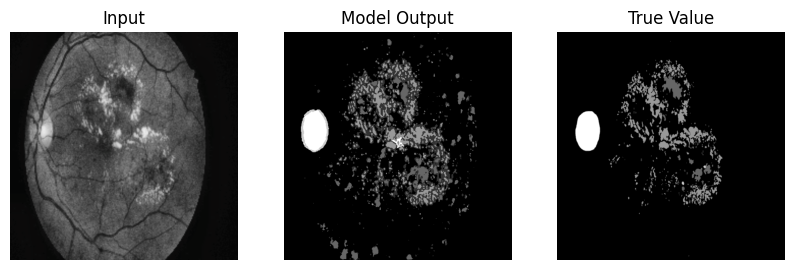

{0: 230488, 1: 8720, 2: 13010, 3: 687, 4: 5134, 5: 4105}
{0: 251460, 1: 1294, 2: 4267, 3: 297, 4: 1193, 5: 3633}


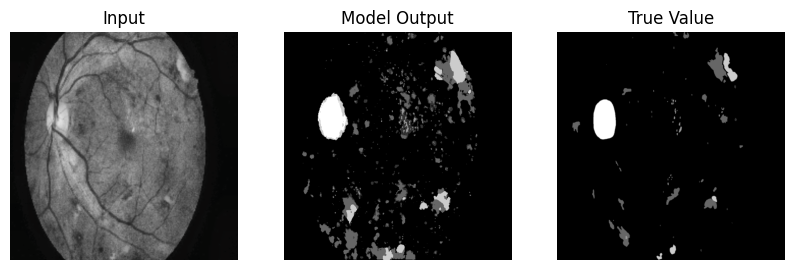

{0: 236904, 1: 12053, 2: 2793, 3: 2823, 4: 2001, 5: 5570}
{0: 255436, 1: 772, 2: 519, 3: 512, 4: 76, 5: 4829}


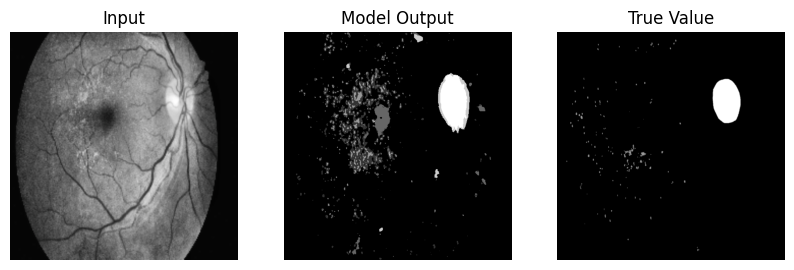

{0: 234376, 1: 8434, 2: 9776, 3: 1511, 4: 2293, 5: 5754}
{0: 252627, 1: 1150, 2: 2048, 3: 1088, 4: 84, 5: 5147}


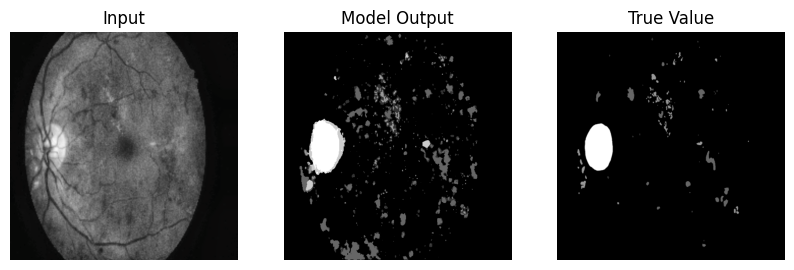

{0: 231271, 1: 11399, 2: 4330, 3: 4445, 4: 4719, 5: 5980}
{0: 247963, 1: 1684, 2: 2218, 3: 1476, 4: 3583, 5: 5220}


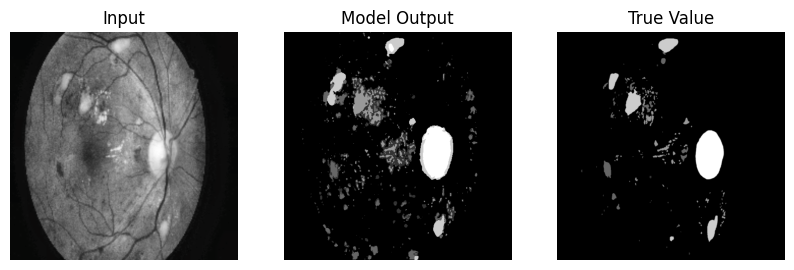

{0: 232566, 1: 10549, 2: 4163, 3: 2063, 4: 6107, 5: 6696}
{0: 251269, 1: 1493, 2: 1363, 3: 731, 4: 1617, 5: 5671}


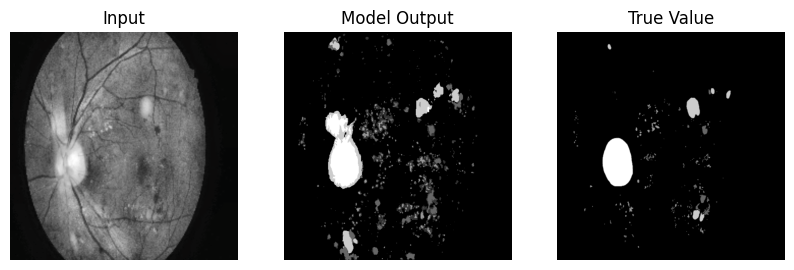

{0: 217927, 1: 12748, 2: 19057, 3: 818, 4: 6201, 5: 5393}
{0: 228568, 1: 3655, 2: 24346, 3: 506, 4: 467, 5: 4602}


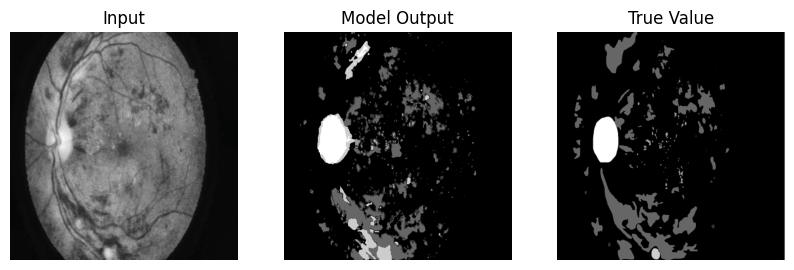

{0: 243332, 1: 7042, 2: 2722, 3: 1820, 4: 2198, 5: 5030}
{0: 256772, 1: 590, 2: 589, 3: 645, 4: 71, 5: 3477}


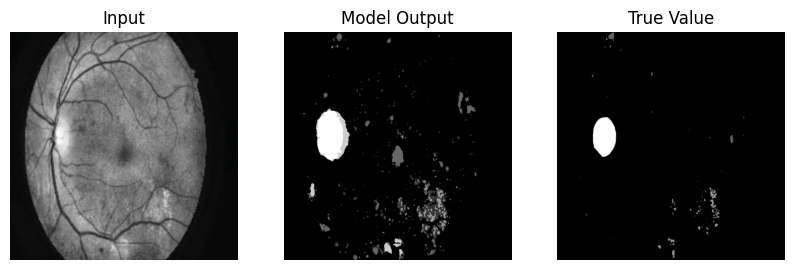

{0: 231123, 1: 6601, 2: 13203, 3: 2918, 4: 1984, 5: 6315}
{0: 253088, 1: 765, 2: 765, 3: 1558, 4: 104, 5: 5864}


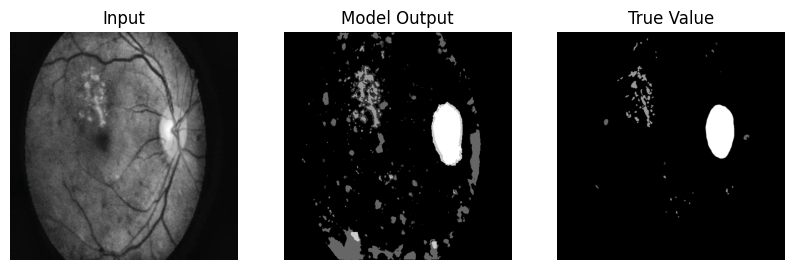

In [ ]:
inference2(best_model, test_dataloader1, 9, 'cuda')

C:\Users\valkr\AppData\Local\Temp\ipykernel_18404\1381794507.py:9: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  outputs = torch.nn.functional.softmax(outputs)


{0: 167204, 1: 23451, 2: 48685, 3: 5516, 4: 6702, 5: 10586}
{0: 241373, 1: 4124, 2: 5105, 3: 7602, 4: 110, 5: 3830}


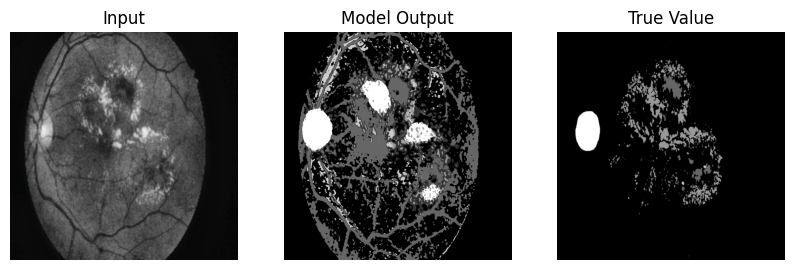

{0: 185616, 1: 18587, 2: 12698, 3: 2776, 4: 27193, 5: 15274}
{0: 251460, 1: 1294, 2: 4267, 3: 297, 4: 1193, 5: 3633}


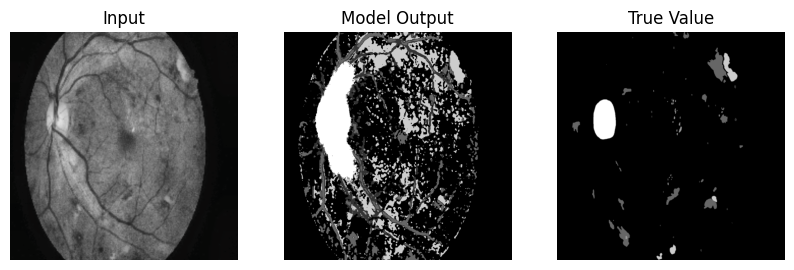

{0: 146942, 1: 19985, 2: 21251, 3: 6278, 4: 23985, 5: 43703}
{0: 255436, 1: 772, 2: 519, 3: 512, 4: 76, 5: 4829}


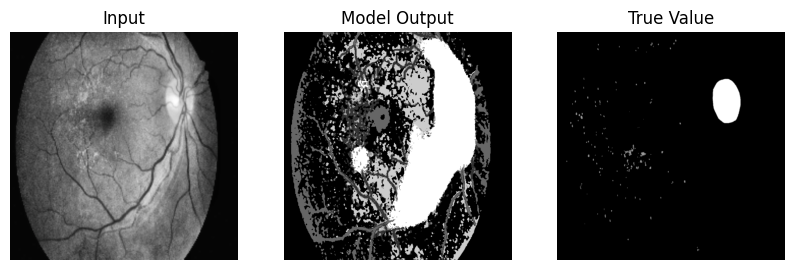

{0: 203025, 1: 12365, 2: 21230, 3: 1623, 4: 11589, 5: 12312}
{0: 252627, 1: 1150, 2: 2048, 3: 1088, 4: 84, 5: 5147}


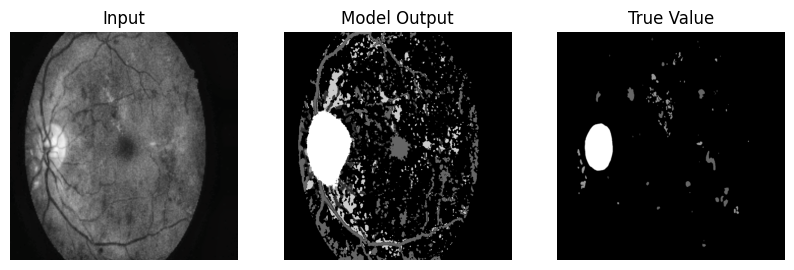

{0: 171309, 1: 21040, 2: 10596, 3: 5161, 4: 17295, 5: 36743}
{0: 247963, 1: 1684, 2: 2218, 3: 1476, 4: 3583, 5: 5220}


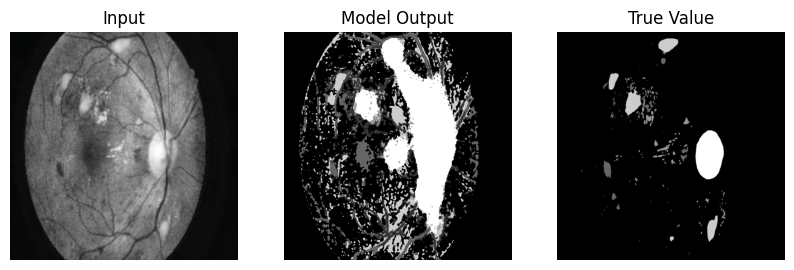

{0: 181642, 1: 23063, 2: 7375, 3: 5871, 4: 16193, 5: 28000}
{0: 251269, 1: 1493, 2: 1363, 3: 731, 4: 1617, 5: 5671}


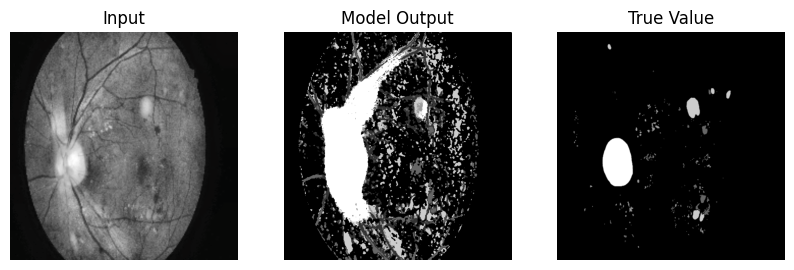

{0: 165926, 1: 21898, 2: 8842, 3: 3972, 4: 39358, 5: 22148}
{0: 228568, 1: 3655, 2: 24346, 3: 506, 4: 467, 5: 4602}


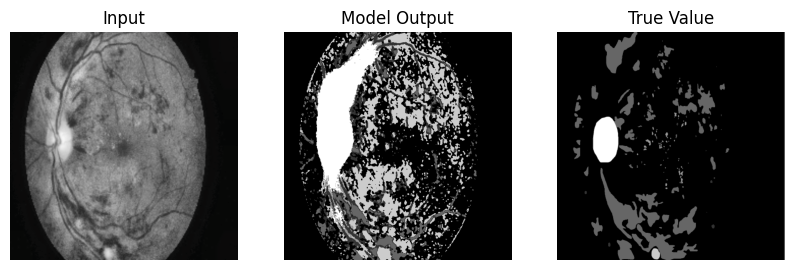

{0: 165883, 1: 22117, 2: 4467, 3: 6428, 4: 27531, 5: 35718}
{0: 256772, 1: 590, 2: 589, 3: 645, 4: 71, 5: 3477}


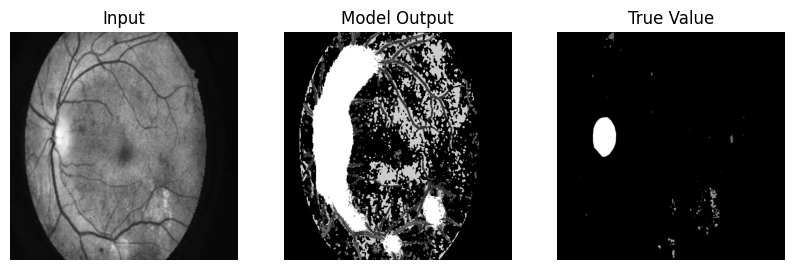

{0: 186875, 1: 12456, 2: 36140, 3: 2905, 4: 6755, 5: 17013}
{0: 253088, 1: 765, 2: 765, 3: 1558, 4: 104, 5: 5864}


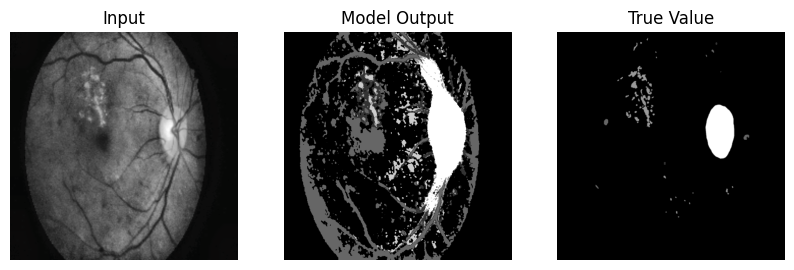

In [ ]:
inference2(best_model, test_dataloader1, 9, 'cuda')

In [ ]:
model2 = uNetModel(6)
criterion2 = torch.nn.CrossEntropyLoss()
optimizer2 = torch.optim.Adam(model2.parameters(), lr=0.001)

In [ ]:
import gc
torch.cuda.empty_cache()
gc.collect()

In [ ]:
train_loss2, bestmodel2 = train(
    model2,
    criterion2,
    optimizer2,
    train_dataloader,
    50,
    True,
    6,
    'cuda'
)

In [ ]:
def inference2(model, dataloader, num_images, device, mean=[0.2816, 0.2817, 0.2816], std=[0.1992, 0.1991, 0.1991]):
  model.to(device)
  model.eval()
  with torch.no_grad():
    for idx in range(num_images):
        image, mask = next(iter(dataloader))
        
        outputs = model(image.to(device))
        outputs = torch.nn.functional.softmax(outputs)
        image = unnormalize(image[idx], mean, std)  # Unnormalize the image
        image_np = np.array(image).transpose(1, 2, 0)
        output_np = np.argmax(np.array(outputs[idx].cpu()), axis=0)
        
        unique_values, counts = np.unique(output_np, return_counts=True)
        count_dict = dict(zip(unique_values, counts))
        print(count_dict)

        unique_values, counts = np.unique(mask[idx], return_counts=True)
        count_dict = dict(zip(unique_values, counts))
        print(count_dict)

        # Display images side by side
        fig, axes = plt.subplots(1, 3, figsize=(10, 5))
        axes[0].imshow(image_np)  # Assuming batch size is 1
        axes[0].set_title('Input')
        axes[0].axis('off')
        axes[1].imshow(output_np.squeeze(), cmap="gray")  # Assuming batch size is 1
        axes[1].set_title('Model Output')
        axes[1].axis('off')
        axes[2].imshow(np.array(mask[idx]).squeeze(), cmap='gray')
        axes[2].set_title('True Value')
        axes[2].axis('off')
        plt.show()

In [ ]:
inference2(model, test_dataloader, 9, 'cuda')

### Third Attempt

In [ ]:
import cv2
import os

In [ ]:
def generate_patches(image_path, mask_path, mask_class, output_folder, resize_size, patch_size):
    image_list = os.listdir(image_path)
    mask_list = []

    for dir in mask_class:
        mask_list.append(os.listdir(f"{mask_path}/{dir[0]}"))

    for image_name in image_list:
        original_image = cv2.imread(f"{image_path}/{image_name}")
        resized_image = cv2.resize(original_image, resize_size)

        if not os.path.isdir(f"{output_folder}/images/"):
            os.makedirs(f"{output_folder}/images/")
            print("image directory created")

        image_output_path = f"{output_folder}/images/{image_name[:-4]}"

        patch_num = cut_patches(resized_image, resize_size, patch_size, image_output_path)


        merged_mask = np.zeros(((original_image.shape[0], original_image.shape[1])), dtype=np.uint8)
        for class_idx, mask_dir in enumerate(mask_class):
            mask_name = f"{image_name[:-4]}_{mask_dir[1]}.tif"
            if mask_name in mask_list[class_idx]:
                mask = cv2.imread(f"{mask_path}/{mask_dir[0]}/{mask_name}")
                mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
                merged_mask[mask > 0] = (class_idx + 1)

        merged_mask_image = cv2.resize(merged_mask, resize_size)
        
        if not os.path.isdir(f"{output_folder}/masks/"):
            os.makedirs(f"{output_folder}/masks/")
            print("mask directory created")

        mask_output_path = f"{output_folder}/masks/{image_name[:-4]}"
        patch_num = cut_patches(merged_mask_image, resize_size, patch_size, mask_output_path)
    
        print(f"Finished {image_name}, {patch_num} patches made")

        
def cut_patches(image, resize_size, patch_size, output_path):
    num_horizontal_patches, num_vertical_paths  = resize_size[1] // patch_size[1], resize_size[0] // patch_size[0]
    patch_num = 0
    for i in range(num_horizontal_patches):
        for j in range(num_vertical_paths):
            x1 = i*patch_size[1]
            x2 = x1+patch_size[1]
            y1 = j*patch_size[0]
            y2 = y1+patch_size[0]

            patch = image[y1:y2, x1:x2]
            
            # unique_values, counts = np.unique(patch, return_counts=True)
            # # Create a dictionary to store counts
            # count_dict = dict(zip(unique_values, counts))
            # print(count_dict)
            
            cv2.imwrite(f"{output_path}_{patch_num}.jpg", patch)
            patch_num += 1

    return patch_num

In [ ]:
image_file = "../input/IDRID/A.%20Segmentation/A. Segmentation/1. Original Images/a. Training Set"
train_mask_file = "../input/IDRID/A.%20Segmentation/A. Segmentation/2. All Segmentation Groundtruths/a. Training Set"
test_main_file = "../input/IDRID/A.%20Segmentation/A. Segmentation/2. All Segmentation Groundtruths/b. Testing Set"
class_path = [["1. Microaneurysms","MA"], ["2. Haemorrhages","HE"], ["3. Hard Exudates","EX"], ["4. Soft Exudates","SE"], ["5. Optic Disc", "OD"]]
output_folder = "../input/IDRID_Patches/Train"

generate_patches(image_file, train_mask_file, class_path, output_folder, (2560,2560), (512,512))

In [ ]:
class PatchDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform, mask_transform, mean, std):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform
        self.mask_transform = mask_transform
        self.mean = mean
        self.std = std        
        self.image_list = os.listdir(image_paths)


    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        image_name = self.image_list[idx]
        image = Image.open(f"{self.image_paths}/{image_name}")
        enhanced_image = enhance_contrast(image, False) #enhance contrast of image

        mask = Image.open(f"{self.mask_paths}/{image_name}")

        seed = np.random.randint(2147483647) # make a seed with numpy generator

        if self.transform is not None:
            random.seed(seed) # apply this seed to img transforms
            torch.manual_seed(seed)
            enhanced_image = self.transform(enhanced_image)
            random.seed(seed) # apply this seed to img transforms
            torch.manual_seed(seed)
            mask = self.mask_transform(mask)

        #normalising image
        mean = torch.tensor(self.mean).reshape(-1, 1, 1)
        std = torch.tensor(self.std).reshape(-1, 1, 1)

        enhanced_image = ( enhanced_image - mean )/std


        # unique_values, counts = np.unique(mask, return_counts=True)
        # # Create a dictionary to store counts
        # count_dict = dict(zip(unique_values, counts))
        # print(count_dict)

        return enhanced_image, mask

In [ ]:
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor()
])

aug_transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomVerticalFlip(0.5),
    transforms.RandomRotation((-45,45)),
    transforms.ToTensor()
])

mask_transform = transforms.Compose([
    transforms.Resize((512, 512)),
    ToTensorWithoutScaling()
])

mask_aug_transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomVerticalFlip(0.5),
    transforms.RandomRotation((-45,45)),
    ToTensorWithoutScaling()
])


# Initialize your dataset - 1/3 unagumented and 2/3 augmented
train_dataset = PatchDataset(image_paths = '../input/IDRID_Patches/Train/images',
                              mask_paths = '../input/IDRID_Patches/Train/masks',
                              transform=transform,
                              mask_transform=mask_transform,
                              mean=[0.2816, 0.2817, 0.2816],
                              std=[0.1992, 0.1991, 0.1991])
total_data = [train_dataset]
train_dataloader = DataLoader(train_dataset, batch_size=9, shuffle=True)


#augmented data
# for i in range(2):
#   augmented_data = PatchDataset(image_paths = '../input/IDRID_Patches/images',
#                               mask_paths = '../input/IDRID_Patches/masks',
#                               transform=aug_transform,
#                               mask_transform=mask_aug_transform,
#                               mean=[0.2816, 0.2817, 0.2816],
#                               std=[0.1992, 0.1991, 0.1991])
#   total_data.append(augmented_data)

# total_train_dataset = ConcatDataset(total_data)

# test_dataset = RetinalDataset(image_paths = '../input/IDRID_Merged/test/images',
#                               mask_paths = test_main_file,
#                               transform=transform,
#                               masktransform=mask_transform,
#                               mean=[0.2816, 0.2817, 0.2816],
#                               std=[0.1992, 0.1991, 0.1991])

# Initialize the dataloader
# train_dataloader = DataLoader(total_train_dataset, batch_size=9, shuffle=True)
# test_dataloader = DataLoader(test_dataset, batch_size=9, shuffle=False)

Image batch shape: torch.Size([9, 3, 512, 512])
Masks batch shape: torch.Size([9, 1, 512, 512])


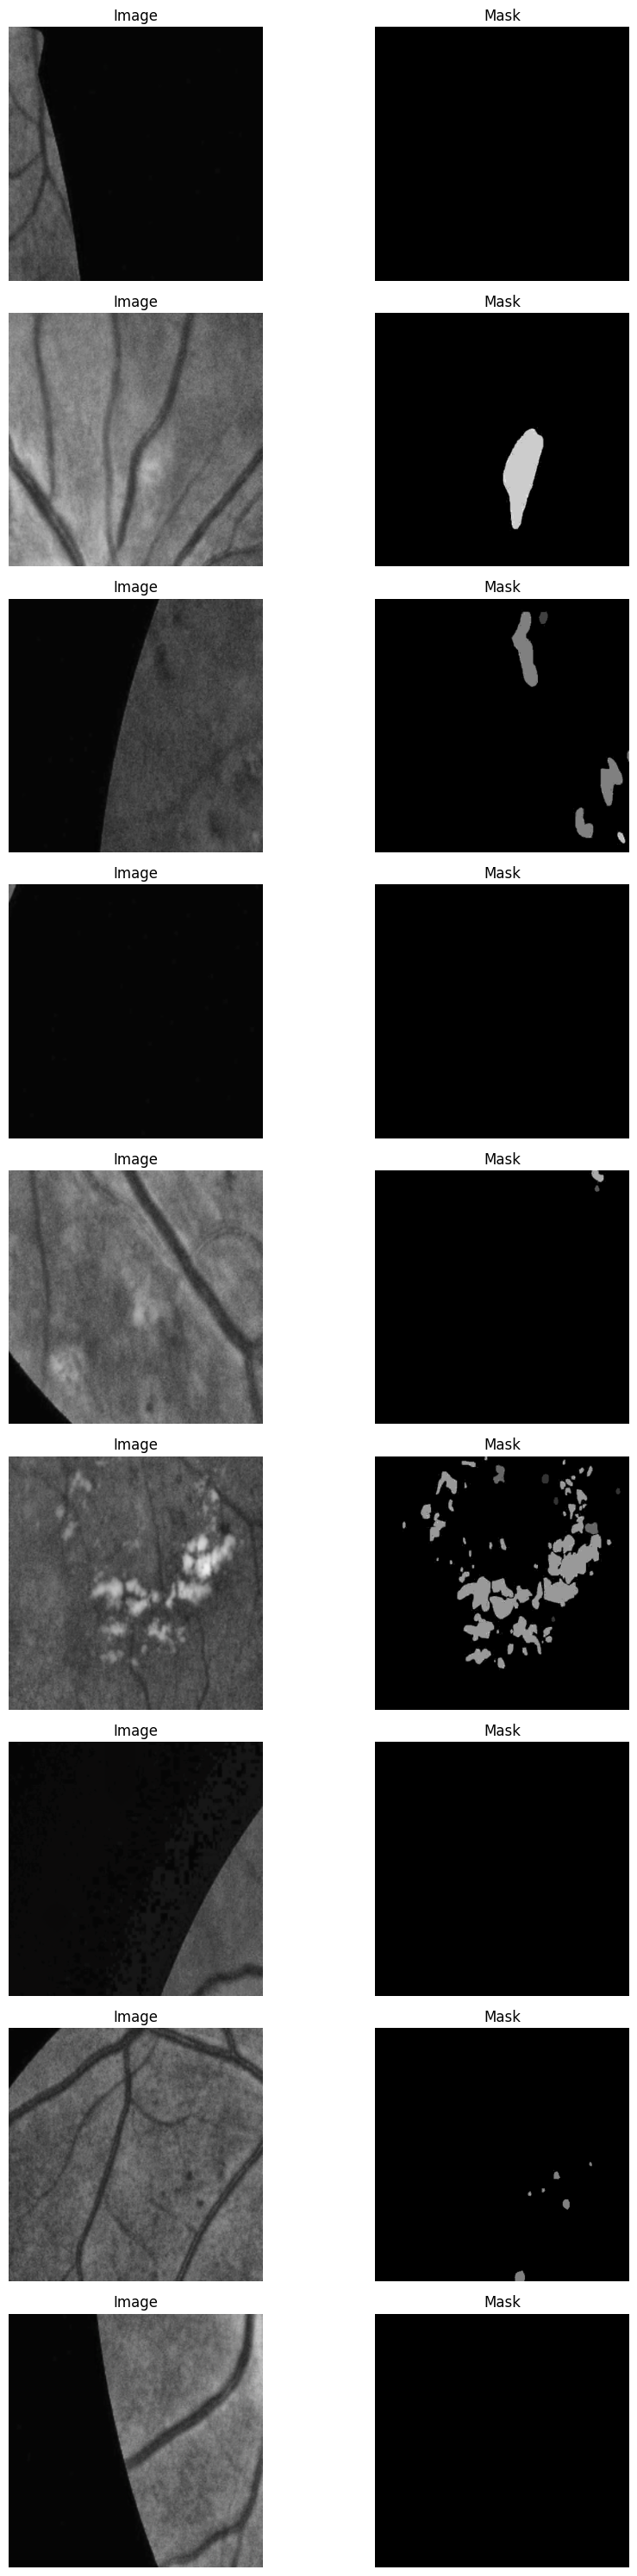

In [ ]:
visualise_dataset(train_dataloader)

In [ ]:
def train(model, criterion, optimiser, dataloader, num_epochs, include_dice,  n_classes, device):
  # model.to(device)
  model.train()
  loss_container = []
  best_model = None

  for epoch in range(num_epochs):
    total_loss = 0
    for idx, (image, mask) in enumerate(tqdm(dataloader)):
      (image, mask) = (image.to(device), mask.to(device))
      outputs = model(image)

      return outputs
      
    #   mask_one_hot = one_hot_encode(mask, 6)
    #   loss = criterion(outputs, mask_one_hot)
      loss = criterion(outputs, (torch.squeeze(mask, dim=1)).long())
      # loss = focal_tversky(outputs, mask)
      # if include_dice:
      #   loss += dice_loss(outputs, mask, n_classes)
      optimiser.zero_grad()
      loss.backward()
      optimiser.step()

      total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    if len(loss_container) > 0 and avg_loss < min(loss_container):
      best_model = model
      torch.save(best_model, "bestmodel3.pth")
      print("best model found")

    loss_container.append(avg_loss)
    print(f"Epoch {epoch+1} completed, training loss: {avg_loss:.2f}")

  return loss_container, best_model

In [ ]:
model = uNetModel(6)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
import gc
torch.cuda.empty_cache()
gc.collect()

In [ ]:
train_loss, best_model = train(
    model,
    criterion,
    optimizer,
    train_dataloader,
    10,
    False,
    6,
    'cpu'
)